# Encoder

Each encoder layer contains:

1. Self-Attention:
    * Captures relationships within the sequence.
2. Feedforward Network (FFN):
    * Two linear layers with a ReLU/GELU activation in between.
3. Add & Normalize:
    * Residual connection and layer normalization.


<div style="text-align: center;">
    <img src="img/encoder.PNG" height="400px"/>
</div>

## Self-Attention

### Self-Attention Mechanism

Self-attention enables each token in the input sequence to attend to every other token in the sequence.

#### Step 1: Compute Three Vectors for Each Token
- **Query (𝑄)**: What the token wants to know.
- **Key (𝐾)**: How relevant a token is for answering.
- **Value (𝑉)**: The content of the token.

#### Step 2: Calculate Attention Scores
The attention score is computed as follows:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V
$$

Where:

- $softmax$ ensures the scores are normalized.
- $d_k$ is the scaling factor to stabilize gradients.


In [11]:
import jax
import jax.numpy as jnp
from typing import Optional, Tuple, List
import matplotlib.pyplot as plt

In [9]:
def scaled_dot_product(
    q: jnp.ndarray, 
    k: jnp.ndarray, 
    v: jnp.ndarray, 
    mask: Optional[jnp.ndarray] = None,
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """
    Compute scaled dot-product attention.

    Args:
        q: Query tensor of shape (..., seq_len, d_k).
        k: Key tensor of shape (..., seq_len, d_k).
        v: Value tensor of shape (..., seq_len, d_k).
        mask: Optional mask tensor of shape (..., seq_len, seq_len).
    
    Returns:
        values: Tensor of shape (..., seq_len, d_k) containing the attention-weighted values.
        attention: Tensor of shape (..., seq_len, seq_len) containing attention scores.
    """
    d_k = q.shape[-1]  # Dimensionality of key vectors
    attn_logits = jnp.matmul(q, jnp.swapaxes(k, -2, -1))  # Compute attention logits
    attn_logits = attn_logits / jnp.sqrt(d_k)  # Scale by sqrt(d_k)

    if mask is not None:
        attn_logits = jnp.where(mask == 0, -1e9, attn_logits)  # Apply mask with large negative value

    attention = jax.nn.softmax(attn_logits, axis=-1)  # Softmax over last axis
    values = jnp.matmul(attention, v)  # Compute weighted values
    return values, attention



Output values shape: (1, 5, 4)
Attention shape: (1, 5, 5)


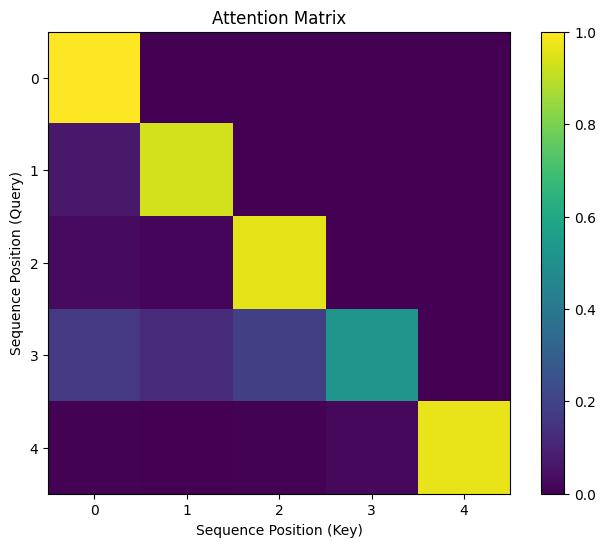

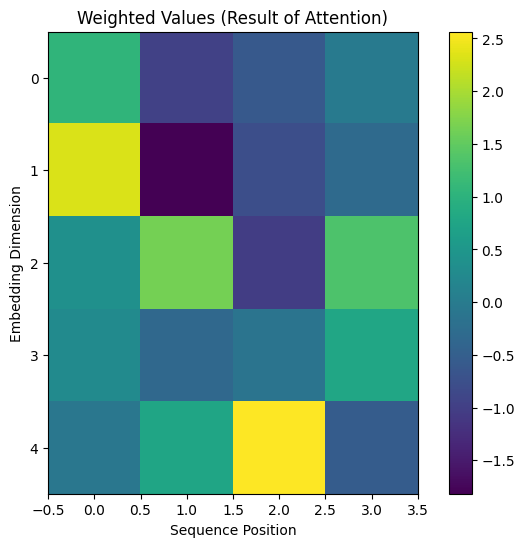

In [13]:
key = jax.random.PRNGKey(0)

# Define dimensions
seq_len = 5
d_k = 4  # Dimensionality of the key/query/value vectors

# Create random tensors for q, k, v
q = jax.random.normal(key, (1, seq_len, d_k))  # Query tensor of shape (1, seq_len, d_k)
k = jax.random.normal(key, (1, seq_len, d_k))  # Key tensor of shape (1, seq_len, d_k)
v = jax.random.normal(key, (1, seq_len, d_k))  # Value tensor of shape (1, seq_len, d_k)

# Optional mask encoding matrix
mask = jnp.tril(jnp.ones((seq_len, seq_len)), k=0)

# Test the function
values, attention = scaled_dot_product(q, k, v, mask=mask)

# Check the shape of the output
print(f"Output values shape: {values.shape}")
print(f"Attention shape: {attention.shape}")
plt.figure(figsize=(8, 6))
plt.imshow(attention[0], cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.title("Attention Matrix")
plt.xlabel("Sequence Position (Key)")
plt.ylabel("Sequence Position (Query)")
plt.show()

# Plot the values (weighted sum of value vectors)
plt.figure(figsize=(8, 6))
plt.imshow(values[0], cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.title("Weighted Values (Result of Attention)")
plt.xlabel("Sequence Position")
plt.ylabel("Embedding Dimension")
plt.show()

### Multi-Head Attention

Instead of using a single attention mechanism, **Multi-Head Attention** splits the query, key, and value vectors into multiple "heads":

1. Split $Q, K, V$ into multiple heads.
2. Perform attention for each head independently.
3. Concatenate the results and project back to the original model dimension.
